## Introduction

This is the third in a series of lessons related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the first lesson we wrote an ADQL query to collect data from the Gaia database for stars in a region where GD-1 is known to be visible.

In the second lesson, we selected stars whose proper motion is consistent with being in GD-1, in two ways: first, using a Pandas DataFrame and a Boolean Series; then, using ADQL to do the selection on the Gaia server.

The next step in the analysis is to select candidate stars based on photometry.  The following figure from the paper is a color-magnitude diagram for stars selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

The shaded area shows stars with the characteristics we expect for a star in GD-1, which are "older and more metal poor" than stars in the background.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia
    !mkdir data

## Reloading the data

Picking up where we left off, let's reload the data from the previous query.

In [24]:
from astropy.table import Table

filename = 'gd1_results5.fits'
results5 = Table.read(filename)

Here's what the results look like, plotting coordinates in ICRS for the selected stars.

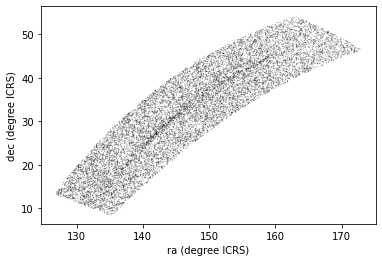

In [25]:
import matplotlib.pyplot as plt

x = results5['ra']
y = results5['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

In the previous notebook, we used `pyia` and `gala` to transform thes coordinates into the `GD1Koposov10` frame, and we combined the original and transformed coordinates in a Pandas `DataFrame`.

As an exercise, let's encapsulate the code for these steps in a function.  Here's an outline:

In [26]:
from pyia import GaiaData
import astropy.units as u
import gala.coordinates as gc

def make_dataframe(table):
    """Transform coordinates and return a DataFrame.
    
    table: Astropy table
    
    returns: Pandas DataFrame
    """
    # transform coordinates
    # ADD CODE HERE

    # make the DataFrame
    df = table.to_pandas()
    
    # add coordinates and proper motion to the DataFrame
    # ADD CODE HERE
    
    return df

In [27]:
# Solution

from pyia import GaiaData
import astropy.units as u
import gala.coordinates as gc

def make_dataframe(table):
    """Transform coordinates and return a DataFrame.
    
    table: Astropy table
    
    returns: Pandas DataFrame
    """
    # transform coordinates
    gaia_data = GaiaData(table)

    c_sky = gaia_data.get_skycoord(distance=8 * u.kpc, 
                                   radial_velocity=0 * u.km/u.s)
    c_gd1 = gc.reflex_correct(
                c_sky.transform_to(gc.GD1Koposov10))

    # make the DataFrame
    df = table.to_pandas()
    
    # add coordinates and proper motion to the DataFrame
    df['phi1'] = c_gd1.phi1
    df['phi2'] = c_gd1.phi2
    df['pm_phi1'] = c_gd1.pm_phi1_cosphi2
    df['pm_phi2'] = c_gd1.pm_phi2
    return df

Here's how we use `make_dataframe`

In [28]:
df5 = make_dataframe(results5)
len(df5)

13976

And here's what the results look like in the `GD1` frame.

In [ ]:
x = df5['phi1']
y = df5['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

## Selecting on proper motion again

Maybe but this section?

In [18]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

In [19]:
def between(x, low, high):
    """Make a Boolean Series.
    
    x: Pandas Series
    low: lower bound
    high: upper bound
    
    returns: Boolean Series
    """
    return (x > low) & (x < high)

In [21]:
pm_mask = (between(df5['pm_phi1'], pm1_min, pm1_max) & 
            between(df5['pm_phi2'], pm2_min, pm2_max))

pm_mask.sum()

3979

In [22]:
candidates = df5[pm_mask]

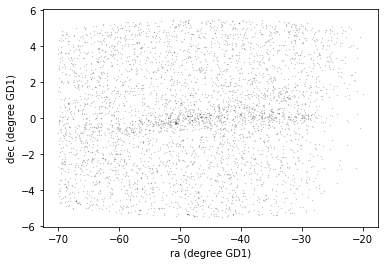

In [23]:
x = candidates['phi1']
y = candidates['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

## Getting photometry data

The Gaia dataset contains some photometry data, including the variable `bp_rp`, which we used in the original query to select stars with BP - RP color between -0.75 and 2.

TODO: Can we say more about what that's meant to do, and where those values come from?

But to select stars with the age and metal richness we expect in GD-1, we will use `g − i` color and apparent `g`-band magnitude, which are available from the Pan-STARRS survey.

Conveniently, the Gaia server provides data from Pan-STARRS in a table in the same database we have been using, so we can access it by making ADQL queries.

In general, looking up a star from the Gaia table and finding the corresponding star in the Pan-STARRS table is not easy.  This kind of cross matching is not always possible, because a star might appear in one catalog and not the other.  And even when both stars are present, there might be a clear one-to-one relationship between stars in the two catalogs.

Fortunately, smart people have worked on this problem, and the Gaia database include cross-matching tables that suggest a best neighbor in the Pan-STARRS catalog for many stars in the Gaia catalog.

[This document describes the cross matching process](https://gea.esac.esa.int/archive/documentation/GDR2/Catalogue_consolidation/chap_cu9val_cu9val/ssec_cu9xma/sssec_cu9xma_extcat.html).




So the good news is that the hard cross-matching work has been done for us.

The bad news is that using it is not easy.

But the good news is that using it is an opportunity to learn about one of the most important tools for working with databases: "joining" tables.

In general, a "join" is an operation where you match up records with one table with records from another table using some kind of identifier as a "key".

In this example:

* Stars in the Gaia dataset are identified by `source_id`.

* Stars in the Pan-STARRS dataset are identified by `obj_id`.

For each candidate star we have selected so far, we have the `source_id`; the goal is to find the `obj_id` for the same star (we hope) in the Pan-STARRS catalog.

To do that we will:

1. Make a table that contains the `source_id` for each star we have selected, and upload the table to the Gaia server, and

2. Use the `JOIN` operator to look up each `source_id` in the `gaiadr2.panstarrs1_best_neighbour` table, which contains the results the `obj_id` of the best match for each star in the Gaia catalog; then we'll 

3. Use the `JOIN` operator again to look up each `obj_id` in the `panstarrs1_original_valid` table, which contains the Pan-STARRS photometry data we want.

Let's start with the first step, uploading a table.


## Preparing a table for uploading

For each candidate star we have selected, we want to find the corresponding row in the `gaiadr2.panstarrs1_best_neighbour` table.

In order to do that, we have to:

1. Write the table in a local file in a format called XML VOTABLE, which is a "serialized" format suitable for transmitting a table over a network.

2. Write an ADQL query that refers to the uploaded table.

3. Change the way we submit the job to indicate that we want to upload a table.

The first step is not too difficult because Astropy provides a function called `writeto` that can write a `Table` in `XML`.

[The documentation of this process is here](https://docs.astropy.org/en/stable/io/votable/).

First we have to convert our Pandas `DataFrame` to an Astropy `Table`.

In [32]:
candidate_table = Table.from_pandas(candidates)
type(candidate_table)

astropy.table.table.Table

Now we can use `writeto` to write the file.

Notice that we select a single column from the table, `source_id`.
We could write the entire table to a file, but that would take longer to transmit over the network, and we really only need one column.

In [33]:
from astropy.io.votable import from_table, writeto

votable = from_table(candidate_table[['source_id']])
writeto(votable, 'candidates.xml')

**Exercise:** There's a gotcha here we want to warn you about.  Why do you think we used double brackets to specify the column we wanted?  What happens if you use single brackets?

Run these cells to find out.

In [34]:
table = candidate_table[['source_id']]
type(table)

astropy.table.table.Table

In [36]:
column = candidate_table['source_id']
type(column)

astropy.table.column.Column

In [ ]:
# writeto(column, 'candidates.xml')

## Uploading a table

[Here's the documentation that explains how to run a query with an uploaded table](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#synchronous-query-on-an-on-the-fly-uploaded-table).

In the spirit of incremental development and testing, let's run it with the simplest possible query.

In [41]:
query = """SELECT *
FROM tap_upload.candidates
"""

This query downloads all rows and all columns from the uploaded table.

Here's how we run it:

In [42]:
from astroquery.gaia import Gaia

In [43]:
job = Gaia.launch_job_async(query=query, 
                       upload_resource='candidates.xml', 
                       upload_table_name='candidates')

INFO: Query finished. [astroquery.utils.tap.core]


And here are the results:

In [44]:
results = job.get_results()
results

source_id
int64
635559124339440000
635674126383965568
635614168640132864
635821980633338624
635518889086133376
635580294233854464
635616539462230400
635877570395672448
635500953302563712


If things go according to plan, the result should contain the same rows and columns as the uploaded table.

In [52]:
len(candidate_table), len(results)

(3979, 3979)

In [53]:
set(candidate_table['source_id']) == set(results['source_id'])

True

## Joining with an uploaded table

Now we're ready for a query that...

In [162]:
query6_base = """SELECT *
FROM gaiadr2.panstarrs1_best_neighbour as best
JOIN tap_upload.candidates as candidates
ON best.source_id = candidates.source_id
"""

In [163]:
query6 = query6_base.format()
print_query(query6)

SELECT *
FROM gaiadr2.panstarrs1_best_neighbour as best
JOIN tap_upload.candidates as candidates
ON best.source_id = candidates.source_id



https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_crossmatches/ssec_dm_panstarrs1_best_neighbour.html

In [164]:
job6 = Gaia.launch_job_async(query=query6, 
                       upload_resource='candidates.xml', 
                       upload_table_name='candidates')

INFO: Query finished. [astroquery.utils.tap.core]


In [165]:
results6 = job6.get_results()
results6

source_id,original_ext_source_id,angular_distance,number_of_neighbours,number_of_mates,best_neighbour_multiplicity,gaia_astrometric_params,source_id_2
,,arcsec,,,,,
int64,int64,float64,int32,int16,int16,int16,int64
635674126383965568,130831388428488720,0.038810268141577516,1,0,1,5,635674126383965568
635600532119713664,130421392285893623,0.04518820915043015,1,0,1,5,635600532119713664
635620701286087424,130651396862917914,0.041749828900538036,1,0,1,5,635620701286087424
635832357274302208,131781401302206851,0.03681655435731799,1,0,1,5,635832357274302208
635593552797727488,130261390007297700,0.04358842687796336,1,0,1,5,635593552797727488
635667426234947072,130641388975047740,0.03987033882131348,1,0,1,5,635667426234947072
635518889086125824,130481372327239910,0.04106496999387337,1,0,1,5,635518889086125824
635672030439913088,130761387533703996,0.034749472459126046,1,0,1,5,635672030439913088


## Join with external table

Example here: https://github.com/smoh/Getting-started-with-Gaia/blob/master/gaia-adql-snippets.md

In [182]:
from astropy.io.votable import from_table, writeto

votable = from_table(results6[['source_id',
                               'original_ext_source_id']])
writeto(votable, 'external.xml')

In [183]:
!head external.xml

<?xml version="1.0" encoding="utf-8"?>
<!-- Produced with astropy.io.votable version 4.0.1.post1
     http://www.astropy.org/ -->
<VOTABLE version="1.4" xmlns="http://www.ivoa.net/xml/VOTable/v1.4" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.4">
 <RESOURCE type="results">
  <TABLE>
   <FIELD ID="source_id" datatype="long" name="source_id" ucd="meta.id;meta.main">
    <DESCRIPTION>
     Unique Gaia source identifier
    </DESCRIPTION>


Run a query with an uploaded user table



https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_external_catalogues/ssec_dm_panstarrs1_original_valid.html

https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#synchronous-query-on-an-on-the-fly-uploaded-table

In [184]:
query7_base = """SELECT *
FROM tap_upload.external as external
"""

In [185]:
query7_base = """SELECT TOP 10 *
FROM gaiadr2.panstarrs1_original_valid
"""

In [186]:
query7_base = """SELECT *
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id
"""

In [187]:
query7 = query7_base.format()
print_query(query7)

SELECT *
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id



In [188]:
job7 = Gaia.launch_job_async(query=query7, 
                       upload_resource='external.xml', 
                       upload_table_name='external')

INFO: Query finished. [astroquery.utils.tap.core]


In [191]:
results7 = job7.get_results()


['obj_name',
 'obj_id',
 'ra',
 'dec',
 'ra_error',
 'dec_error',
 'epoch_mean',
 'g_mean_psf_mag',
 'g_mean_psf_mag_error',
 'g_flags',
 'r_mean_psf_mag',
 'r_mean_psf_mag_error',
 'r_flags',
 'i_mean_psf_mag',
 'i_mean_psf_mag_error',
 'i_flags',
 'z_mean_psf_mag',
 'z_mean_psf_mag_error',
 'z_flags',
 'y_mean_psf_mag',
 'y_mean_psf_mag_error',
 'y_flags',
 'n_detections',
 'zone_id',
 'obj_info_flag',
 'quality_flag',
 'source_id',
 'original_ext_source_id']

https://outerspace.stsci.edu/display/PANSTARRS/PS1+MeanObjectView+table+fields

In [192]:
df7 = results7.to_pandas()
df7.columns

Index(['obj_name', 'obj_id', 'ra', 'dec', 'ra_error', 'dec_error',
       'epoch_mean', 'g_mean_psf_mag', 'g_mean_psf_mag_error', 'g_flags',
       'r_mean_psf_mag', 'r_mean_psf_mag_error', 'r_flags', 'i_mean_psf_mag',
       'i_mean_psf_mag_error', 'i_flags', 'z_mean_psf_mag',
       'z_mean_psf_mag_error', 'z_flags', 'y_mean_psf_mag',
       'y_mean_psf_mag_error', 'y_flags', 'n_detections', 'zone_id',
       'obj_info_flag', 'quality_flag', 'source_id', 'original_ext_source_id'],
      dtype='object')

In [201]:
columns = ['source_id', 'g_mean_psf_mag', 'i_mean_psf_mag']
subset = df7[columns]

In [214]:
merged = pd.merge(candidate5, subset, on='source_id')
merged.head()

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,phi1,phi2,pm_phi1,pm_phi2,g_mean_psf_mag,i_mean_psf_mag
0,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,0.223692,-59.133391,-2.306901,-7.560608,-0.741800,19.287300,17.678101
1,635600532119713664,139.228699,18.685939,-3.974279,-12.342427,0.966999,0.714975,-59.227510,-2.800950,-7.295805,-0.531670,20.450600,19.517700
2,635620701286087424,139.686282,18.881114,-3.355842,-12.925224,-1.298304,0.852420,-58.828179,-3.059248,-7.422251,-1.414040,20.411301,19.503300
3,635832357274302208,140.130153,19.821917,-4.055981,-13.024120,0.700024,0.659552,-57.809692,-2.898062,-7.830145,-0.913733,20.475901,18.804800
4,635593552797727488,139.000700,18.555903,-4.306132,-12.541950,0.299285,0.506318,-59.453906,-2.689347,-7.657516,-0.337478,20.606199,18.895500


## Plot results

https://shapely.readthedocs.io/en/latest/manual.html

In [223]:
merged['g'] = merged['g_mean_psf_mag']
merged['g_minus_i'] = merged['g'] - merged['i_mean_psf_mag']

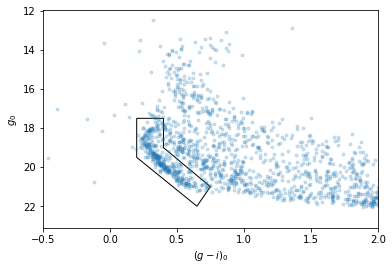

In [224]:
from matplotlib import patches

coords = [(0.2, 17.5), 
          (0.2, 19.5), 
          (0.65, 22),
          (0.75, 21),
          (0.4, 19),
          (0.4, 17.5)]
poly = patches.Polygon(coords, fill=False)

plt.plot(merged['g_minus_i'], merged['g'], '.', alpha=0.2)
plt.gca().add_patch(poly)

plt.gca().invert_yaxis()
plt.xlim([-0.5, 2])

plt.ylabel('$g_0$')
plt.xlabel('$(g-i)_0$');

In [220]:
df = pd.DataFrame(dict(xs=xs, ys=ys))
df.head()

,xs,ys
0,1.609200,19.287300
1,0.932899,20.450600
2,0.908001,20.411301
3,1.671101,20.475901
4,1.710699,20.606199


In [225]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

True


In [232]:
from shapely import geometry

polygon = geometry.Polygon(coords)
photo_mask = pd.Series(np.nan, merged.index)

for i, row in merged.iterrows():
    point = Point(row['g_minus_i'], row['g'])
    photo_mask[i] = polygon.contains(point)

In [233]:
photo_mask.sum()

335

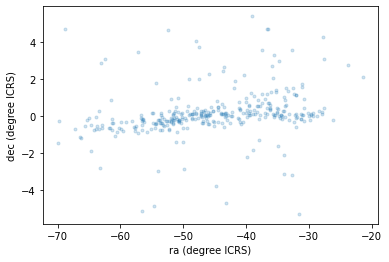

In [243]:
final = merged[photo_mask].copy()

plot_coords(final)